# **Inteligencja obliczeniowa w analizie danych cyfrowych**

## **Projekt 3: Podstawy Gymnasium**

Autorzy: Karolina Surówka, Weronika Hilaszek

In [1]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.5 MB/s eta 0:00:00


## **Cliff Walking**

**Opis gry**

Gra polega na przechodzeniu przez świat siatki od początku do celu, unikając upadku z klifu.

Gra rozpoczyna się od gracza znajdującego się w lokalizacji [3, 0] na siatce o razmiarze 4x12, a cel znajduje się w [3, 11]. Jeśli gracz osiągnie cel, pojedyncza rozgrywa się kończy.

Klif znajduje się w miejscu: [3, 1..10]. Jeśli gracz przesunie się do lokalizacji na klifie, wróci do lokalizacji początkowej.

Gracz wykonuje ruchy, aż dotrze do celu

**Przestrzeń ruchu**

W celu dotarcia do celu agent może wykonać jeden spośrod 4 możliwych ruchów w danej iteracji. Ich oznaczenia znajdują się poniżej.

    0: do góry

    1: w prawo

    2: w dół

    3: w lewo

**Przestrzeń stanów**

Dla ułatwienia poruszania się po planszy została zastosowana przestrzeń stanów, każda komórka ma swój unikatowy numer stanu. Agent na pozycji początkowej zajmuje stan nr 36.


In [ ]:
"""
States or Observations:
0   1   2   3   4   5   6   7   8   9   10  11
12  13  14  15  16  17  18  19  20  21  22  23
24  25  26  27  28  29  30  31  32  33  34  35
36  37  38  39  40  41  42  43  44  45  46  47
"""

'\nStates or Observations:\n0   1   2   3   4   5   6   7   8   9   10  11\n12  13  14  15  16  17  18  19  20  21  22  23\n24  25  26  27  28  29  30  31  32  33  34  35\n36  37  38  39  40  41  42  43  44  45  46  47\n'

**Nagroda**

Każdy krok wiąże się z nagrodą -1, chyba że gracz wkroczy na klif, co skutkuje otrzymaniem nagrody równej -100.

## **SARSA**

Uczenie algorytmu pokonywania trasy do celu wykorzystuje algorytm Sarsa. Jego nazwa jest akronimem od wartości, które przyjmuje i zwraca: s, a, r, s', a'. Łatwo zauważyć, że wykorzystuje on nie tylko obecny stan, wykonywaną akcję oraz zwrócone przez środowisko nagrodę i następny stan, ale również akcję następną, którą agent wykonuje w późniejszym kroku czasowym.

Dopóki nie zostanie osiągnięty stan końcowy algorytm wykonuje akcję a (zapamiętaną w poprzednim kroku czasowym) i obserwuje nagrodę r oraz kolejny stan s'. Wybiera następną akcję a' wedle obranej strategii i zapamiętajuje ją.
Aktualizuje również wartość oczekiwanej nagrody według wzoru:

    Q(s, a) + α(r + γ*Q(s', a) - Q(s, a)).

## **Implementacja**

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch

In [3]:
torch.cuda.is_available()

True

Inicjalizacja Środowiska.

In [4]:
env = gym.make('CliffWalking-v0', )
observation, info = env.reset()

Pomocniczna klasa przechowująca parametry.  
Funkcja `decay_epsilon` aktualizuje wartość parametru epsilon.




In [5]:
class Params:
    def __init__(self, alpha, gamma, n_episodes, epsilon):
        self.n_states = env.observation_space.n
        self.n_actions = env.action_space.n
        self.n_episodes = n_episodes

        self.epsilon = epsilon
        self.epsilon_decay = self.epsilon / (self.n_episodes / 2)
        self.final_epsilon = 0.1

        self.alpha = alpha
        self.gamma = gamma

        self.paths_list = []
        self.rewards_list = []

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

Funkcja  `update_q_table` stworzona w celu aktualizacji tablicy Q.

In [19]:
def update_q_table(Q, state, action, reward, next_state, next_action, params):
    """
    Dla wersji Sarsa:
    Q(S, A) <- Q(S, A) + [α * (r + (γ * Q(S', A'))) -  Q(S, A)]
    """
    Q[state, action] = Q[state, action] + params.alpha * (reward + params.gamma * Q[next_state, next_action] - Q[state, action])
    return Q

Funkcja `epsilon_greedy_policy` odpowiada za wybór akcji jaką agent ma wykonać w zależności od wartości parametru `epsilon`.

In [6]:
def epsilon_greedy_policy(Q, state, params):
    if np.random.rand() < params.epsilon:
        return np.random.choice(params.n_actions)
    else:
        return np.argmax(Q[state])

Poniżej znajduje się funkcja ucząca, jej poszczególne kroki są wytłumaczone w komentarzach.

In [20]:
def learning(params, Q):
  for episode in range(params.n_episodes):
      reward_list = []
      done = False
      obs, info = env.reset()  ## Przyjęcie pozycji początkowej

      # wykonanie pojedynczej zagrywki
      while not done:

          action = epsilon_greedy_policy(Q, obs, params) ## Wybór akcji
          next_obs, reward, terminated, truncated, info = env.step(action) ## Wykonanie akcji
          reward_list.append(reward)
          next_action = epsilon_greedy_policy(Q, next_obs, params) ## Wybór następnej akcji
          Q = update_q_table(Q, obs, action, reward, next_obs, next_action, params) ## Aktualizacja tablicy Q

          # Sprawdzenie czy agent dotarł do celu lub nastąpiło przekroczenie/timelimit
          done = terminated or truncated
          obs = next_obs

      params.rewards_list.append(reward_list) ## Dodanie nagrody
      params.decay_epsilon() ## Aktulizacja parametru epsilon

Pomocnicza funkcja sumująca otrzymane nagrody w poszczególnych rozgrywkach.

In [7]:
def sum_rewards(rewards_list):
  rewards_sum =[]
  for  i in range(len(rewards_list)):
      rewards_sum.append(sum(rewards_list[i]))
  return rewards_sum

Pomocnicza funkcja wizualizująca wyniki.

In [8]:
def visualize_curve(rewards_sum):
    plt.plot(rewards_sum)
    plt.xlabel('Steps')
    plt.ylabel('Rewards')
    plt.title('Rewards per episode')
    plt.show()

**Pierwszy eksperyment**

Wykorzystane parametry:
- alpha=0.1
- gamma=0.9
- n_episodes=200
- epsilon=1.0

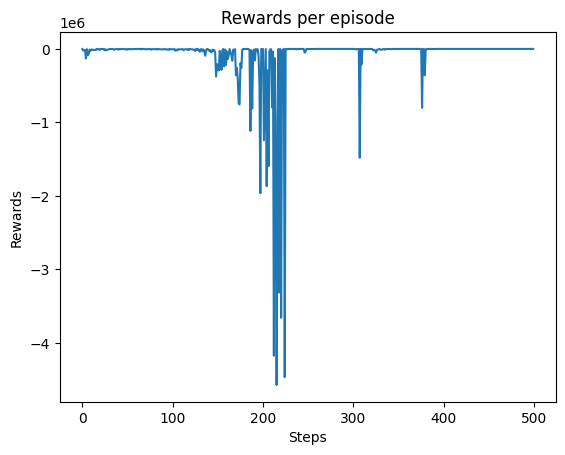

In [21]:
params = Params(alpha=0.1, gamma=0.9, n_episodes=500, epsilon=1.0)
Q = np.zeros((params.n_states, params.n_actions))
learning(params, Q)
rewards_sum = sum_rewards(params.rewards_list)
visualize_curve(rewards_sum)

**Drugi eksperyment**

Wykorzystane parametry:
- alpha=0.01
- gamma=0.9
- n_episodes=500
- epsilon=1.0

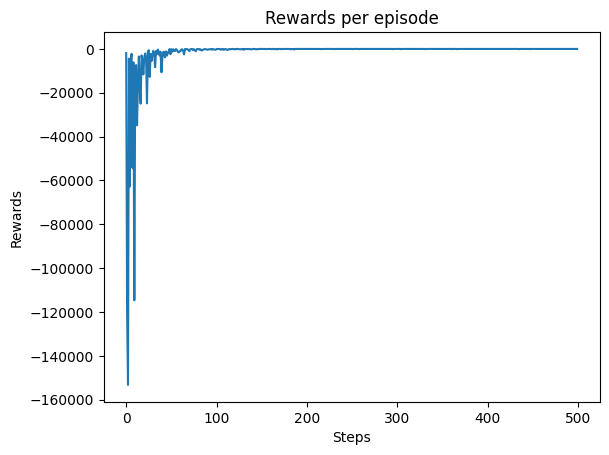

In [ ]:
params2 = Params(alpha=0.01, gamma=0.9, n_episodes=500, epsilon=1.0)
Q2 = np.zeros((params2.n_states, params2.n_actions))
learning(params2, Q2)
rewards_sum2 = sum_rewards(params2.rewards_list)
visualize_curve(rewards_sum2)

**Trzeci eksperyment**

Wykorzystane parametry:
- alpha=0.001
- gamma=0.9
- n_episodes=500
- epsilon=1.0

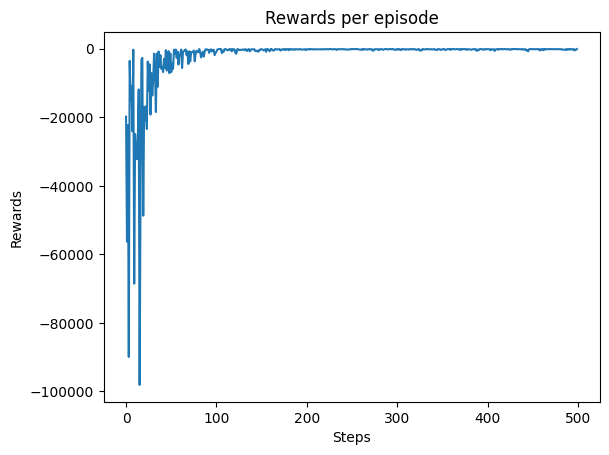

In [ ]:
params3 = Params(alpha=0.001, gamma=0.9, n_episodes=500, epsilon=1.0)
Q3 = np.zeros((params3.n_states, params3.n_actions))
learning(params3, Q3)
rewards_sum3 = sum_rewards(params3.rewards_list)
visualize_curve(rewards_sum3)

**Czwarty eksperyment**

Wykorzystane parametry:
- alpha=0.0001
- gamma=0.9
- n_episodes=500
- epsilon=1.0

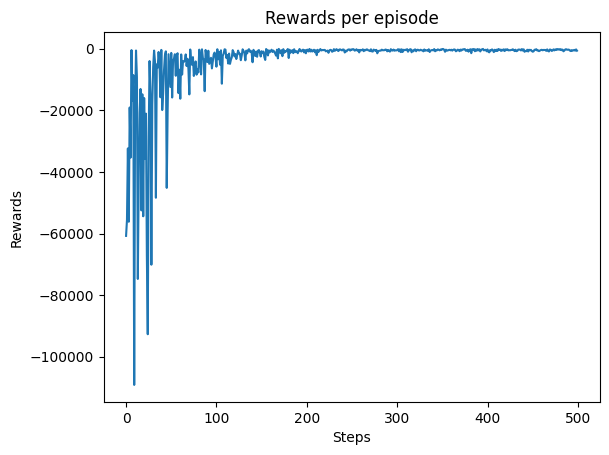

In [ ]:
params4 = Params(alpha=0.0001, gamma=0.9, n_episodes=500, epsilon=1.0)
Q4 = np.zeros((params4.n_states, params4.n_actions))
learning(params4, Q4)
rewards_sum4 = sum_rewards(params4.rewards_list)
visualize_curve(rewards_sum4)

## **Wnioski**

Porównując powyżej przedstawione eksperymenty można wywnioskować, że wraz ze wzrostem wartości parametru `alpha` algorytm jest bardziej stabilny. Uzyskuje większą sumaryczną wartość nagród. Dużo rzadziej występują rozgrywki, dla których obserwowany jest nagły spadek tej wartości w porównaniu do wcześniej rozegranych gier.  
Zbyt wysokie alpha może powodować niestabilność i oscylacje w wynikach, podczas gdy zbyt niskie alpha może znacząco spowolnić proces uczenia lub nawet uniemożliwić agentowi dostateczną adaptację.

## **Algorytm Q-learning**

Algorytm przebiega podobnie, ale tym razem tablica Q jest aktualizowana po każdym kroku. W Q-learning, zamiast używać następnej akcji a' wybranej zgodnie z polityką, należy użyć maksymalnej wartości Q dla następnego stanu s`, niezależnie od wybranej akcji.

In [9]:
def update_ql_table(Q, state, action, reward, next_state, params):
    """
    Aktualizacja tabeli Q dla Q-learning:
    Q(S, A) <- Q(S, A) + α * (R + γ * max(Q(S', a')) - Q(S, A))
    """
    max_next_q = np.max(Q[next_state])
    Q[state, action] = Q[state, action] + params.alpha * (reward + params.gamma * max_next_q - Q[state, action])
    return Q

Poprzedni algorytm zaktualizowany o odwołanie do `update_ql_table`.

In [14]:
def qlearning(params, Q):
  for episode in range(params.n_episodes):
      reward_list = []
      done = False
      obs, info = env.reset()  ## Przyjęcie pozycji początkowej

      # wykonanie pojedynczej zagrywki
      while not done:

          action = epsilon_greedy_policy(Q, obs, params) ## Wybór akcji
          next_obs, reward, terminated, truncated, info = env.step(action) ## Wykonanie akcji
          reward_list.append(reward)
          next_action = epsilon_greedy_policy(Q, next_obs, params) ## Wybór następnej akcji
          Q = update_ql_table(Q, obs, action, reward, next_obs, params) ## Aktualizacja tablicy Q

          # Sprawdzenie czy agent dotarł do celu lub nastąpiło przekroczenie/timelimit
          done = terminated or truncated
          obs = next_obs

      params.rewards_list.append(reward_list) ## Dodanie nagrody
      params.decay_epsilon() ## Aktulizacja parametru epsilon

Eksperymenty przeprowadzono podobnie jak dla SARSA, zmieniając współczynnik `alpha`.

**Pierwszy eksperyment**

Wykorzystane parametry:
- alpha=0.1
- gamma=0.9
- n_episodes=200
- epsilon=1.0

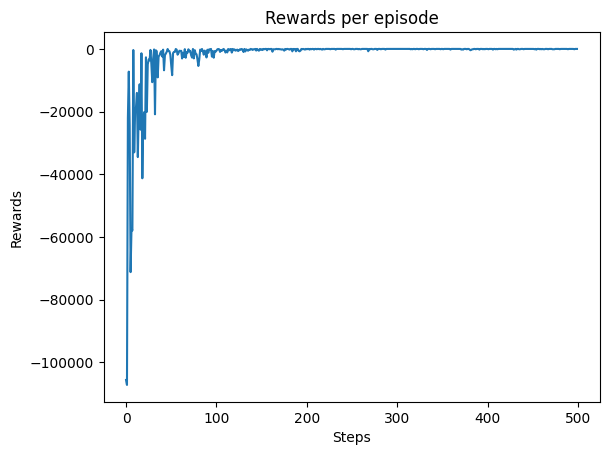

In [16]:
params_ = Params(alpha=0.1, gamma=0.9, n_episodes=500, epsilon=1.0)
Q_ = np.zeros((params_.n_states, params_.n_actions))
qlearning(params_, Q_)
rewards_sum_ = sum_rewards(params_.rewards_list)
visualize_curve(rewards_sum_)

**Drugi eksperyment**

Wykorzystane parametry:
- alpha=0.01
- gamma=0.9
- n_episodes=500
- epsilon=1.0

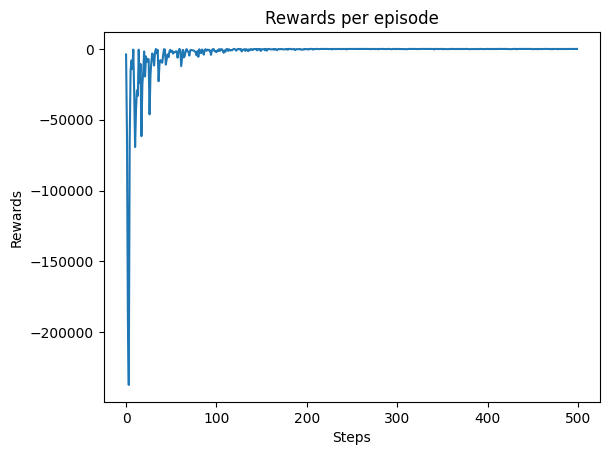

In [15]:
params_2 = Params(alpha=0.01, gamma=0.9, n_episodes=500, epsilon=1.0)
Q_2 = np.zeros((params_2.n_states, params_2.n_actions))
qlearning(params_2, Q_2)
rewards_sum_2 = sum_rewards(params_2.rewards_list)
visualize_curve(rewards_sum_2)

**Trzeci eksperyment**

Wykorzystane parametry:
- alpha=0.001
- gamma=0.9
- n_episodes=500
- epsilon=1.0

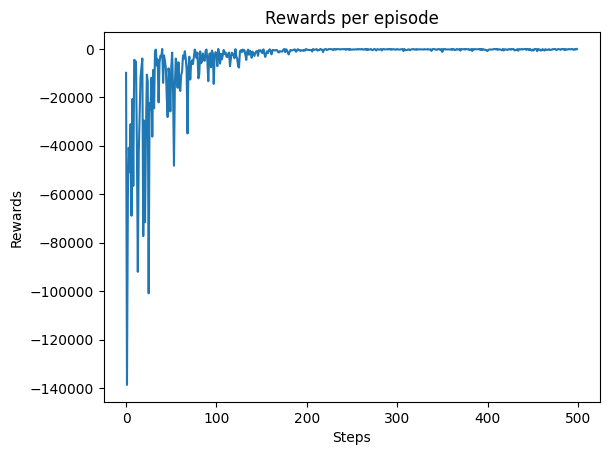

In [17]:
params_3 = Params(alpha=0.001, gamma=0.9, n_episodes=500, epsilon=1.0)
Q_3 = np.zeros((params_3.n_states, params_3.n_actions))
qlearning(params_3, Q_3)
rewards_sum_3 = sum_rewards(params_3.rewards_list)
visualize_curve(rewards_sum_3)

**Czwarty eksperyment**

Wykorzystane parametry:
- alpha=0.0001
- gamma=0.9
- n_episodes=500
- epsilon=1.0

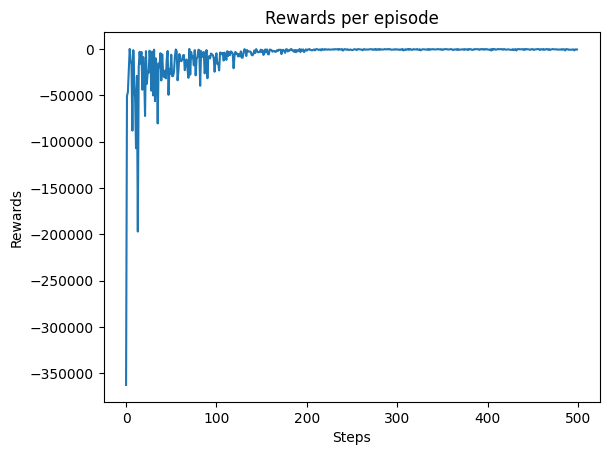

In [18]:
params_4 = Params(alpha=0.0001, gamma=0.9, n_episodes=500, epsilon=1.0)
Q_4 = np.zeros((params_4.n_states, params_4.n_actions))
qlearning(params_4, Q_4)
rewards_sum_4 = sum_rewards(params_4.rewards_list)
visualize_curve(rewards_sum_4)

## **Wnioski**

Wybór współczynnika uczenia `alpha` jest kluczowym aspektem w dostosowywaniu procesu uczenia Q-learning. Zbyt wysokie wartości alpha mogą prowadzić do niestabilności i braku konwergencji, podczas gdy zbyt niskie wartości alpha spowalniają naukę i mogą zapobiegać agentowi w znajdywaniu optymalnej polityki w rozsądnym czasie. Im wyższa `alpha`, tym stabilniejszy proces nauki. W przypadku tych konkretnych eksperymentów, zarówno Sarsa jak i Q-learning wydają się osiągać podobne wyniki w dłuższym okresie, co sugeruje, że obie metody są zdolne do nauki efektywnych strategii. Różnice w krótkoterminowej wydajności i w zakresie zmienności wskazują na to, że Q-learning może być nieco bardziej odporny na lokalne minima i może osiągnąć lepszą wydajność przy odpowiedniej kalibracji współczynnika uczenia `alpha`.

